### Packages & Functions

In [2]:
import numpy as np
from scipy import linalg
import cvxpy as cp
import matplotlib.pyplot as plt
import pickle

In [3]:
from quafu import QuantumCircuit
from quafu import User
from quafu import Task
from quafu import simulate
user = User("IJGwl9xqihdWU8uYGcapqmb1UdhZvmv13rEBV5PVZ1C.Qf0kjNzEzN3AzNxojIwhXZiwCNyEDN6ICZpJye.9JiN1IzUIJiOicGbhJCLiQ1VKJiOiAXe0Jye")
user.save_apitoken()

In [4]:
available_backends = user.get_available_backends()

system_name	 qubits	 status
ScQ-P10   	 10   	 Online
ScQ-P18   	 18   	 Maintenance
ScQ-P136  	 136  	 Online
ScQ-P102  	 102  	 Maintenance
ScQ-P10C  	 10   	 Maintenance
ScQ-XXX   	 2    	 Offline


### Lower bound from SDP

In [5]:
def block_vec(j, n, d):
    # define ket{e_j} \otimes I_d 
    # to calculate the partial trace
    vec = np.zeros(n)
    vec[j] += 1
    return np.kron(vec, np.identity(d))

def SDP0(W, rho, obser_set):
    # SDP for NH bound
    d = len(rho)    
    n = len(obser_set)

    rhoL = np.kron(W, rho)
    S = cp.Variable((n*d, n*d), complex=True)
    Rset = []
    for j in range(n):
        Rset.append(cp.Variable((d, d), complex=True))
    RsetH = []
    for Rj in Rset:
        RsetH.append(Rj.H)

    Rvec = cp.vstack(Rset)
    RvecH = cp.hstack(RsetH)
    Xvec = cp.vstack(obser_set)
    XvecH = cp.hstack(obser_set)

    A = cp.vstack(
        [
            cp.hstack([np.identity(d), RvecH]),
            cp.hstack([Rvec, S])
        ]
    )

    Q = S - Rvec @ XvecH - Xvec @ RvecH + Xvec @ XvecH

    Sjk_set = []
    for j in range(n):
        for k in range(n):
            if j != k:
                Sjk_set.append(
                    block_vec(j, n, d) @ S @ block_vec(k, n, d).T
                )

    constraints = [
        cp.vstack(
            [
                cp.hstack([cp.real(A), -cp.imag(A)]), 
                cp.hstack([cp.imag(A), cp.real(A)])
            ]
        )
        >> 0,
        S == S.H,
        Q >> 0
    ]
        
    for Rj in Rset:
        constraints.append(
            Rj == Rj.H
        )

    for Sjk in Sjk_set:
        constraints.append(
            Sjk == Sjk.H
        )

    obj = cp.Minimize(cp.real(cp.trace(rhoL @ Q)))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver = cp.MOSEK)
    err = prob.value
    Rjopt = []
    for j in range(n):
        Rjopt.append(Rset[j].value)
    return [err, Rjopt]

In [6]:
def commt(A, B):
    return A @ B - B @ A
    
def tr_norm(A):
    return sum(linalg.svdvals(A))
    
def Var(A, rho):
    return np.abs(np.trace(rho @ A @ A) - np.trace(rho @ A)**2)
    
def benchmark(w, obser_set, rho):
    # Ozawa
    n = len(obser_set)
    obser_eff = []
    for j in range(n):
        obser_eff.append(w[j][j]**0.5 * obser_set[j])
    Cp = np.zeros((n, n))
    rhosqrt = linalg.fractional_matrix_power(rho, 1/2)
    for j in range(n):
        for k in range(n):
            alpha = Var(obser_eff[j], rho) + Var(obser_eff[k], rho)
            beta = tr_norm(rhosqrt @ commt(obser_eff[j], obser_eff[k]) @ rhosqrt)
            Cp[j][k] += (1/2 * (alpha - (np.abs(alpha**2-beta**2))**0.5))**0.5
    return 1/(2*(n-1)) * linalg.norm(Cp)**2

In [7]:
def Vec_proj(u, v):
    # projection of v onto u
    proj = (v.conj().T @ u)/(u.conj().T @ u) * u
    return proj

def gram_schmidt(A):
    # Schmidt Orthonormalization
    n = A.shape[1]
    Q = (A[:, 0] / np.linalg.norm(A[:, 0])).reshape(2, 1)
    for j in range(1, n):
        for k in range(Q.shape[1]):
            A[:, j] -= Vec_proj(Q[:, k], A[:, j])
        if np.linalg.norm(A[:, j]) > 1e-6:
            Q = np.append(Q, (A[:, j] / np.linalg.norm(A[:, j])).reshape(2, 1), axis=1)
    return Q

def Proj_opt(Rset, psi):
    # Optimal Projective measurement
    r0 = psi
    rjset = [ r0 ]
    for j in range(len(Rset)):
        if np.linalg.norm(Rset[j] @ psi) > 1e-6:
            rjcandd = Rset[j] @ psi / np.linalg.norm(Rset[j] @ psi)
            check_imag = 0
            for rj in rjset:
                check_imag += np.abs(np.imag(rjcandd.conj().T @ rj))
            if check_imag < 1e-6:
                rjset.append(rjcandd)
    rjmat = np.hstack(rjset)
    rjortho = gram_schmidt(rjmat).conj().T
    phi = np.pi/4
    U = np.array([
        [np.cos(phi), np.sin(phi)],
        [np.sin(phi), -np.cos(phi)]
    ])
    for j in range(len(rjortho)):
        if np.abs(rjortho[j] @ psi) < 0.1 or np.abs(1 - np.abs(rjortho[j] @ psi)) < 0.1:
            rjortho = U @ rjortho
    return rjortho

### Functions for the 'three-state-method'

In [8]:
def three_state(psi, obser):
    Id = np.identity(len(psi))
    psi0 = psi
    psi1 = obser @ psi / np.linalg.norm(obser @ psi)
    psi2 = (Id+obser) @ psi / np.linalg.norm((Id+obser) @ psi)
    return [ psi0, psi1, psi2 ]

def state_prep_U(psi):
    Umat = np.hstack([psi, linalg.null_space(psi.conj().T)])
    return Umat

def ReTr(rho, X, p):
    d = len(rho)
    idd = np.identity(d)
    M = cp.Variable((d, d), complex=True)
    rho1 = rho
    rho2 = X @ rho @ X
    rho3 = (idd + X) @ rho @ (idd + X)
    constraints = [
        M >> 0,
        idd - M >> 0,
        M == M.H
    ]
    constraints0 = constraints + [
        cp.trace(rho1 @ M) == p[0],
        cp.trace(rho2 @ M) == p[1] * np.trace(X @ rho @ X),
        cp.trace(rho3 @ M) == p[2] * np.trace((idd + X) @ rho @ (idd + X))
    ]
    constraints_List = [constraints0]
    rhoX = (rho @ X + X @ rho)/2
    objmin = cp.Minimize(cp.real(cp.trace(M @ rhoX)))
    objmax = cp.Maximize(cp.real(cp.trace(M @ rhoX)))
    for constr in constraints_List:
        probmin = cp.Problem(objmin, constr)
        probmax = cp.Problem(objmax, constr)
        probmin.solve(solver=cp.SCS, use_indirect=True, eps=1e-8)
        probmax.solve(solver=cp.SCS, use_indirect=True, eps=1e-8)
        if np.abs(probmin.value) != np.inf and np.abs(probmax.value) != np.inf:
            return [probmin.value, probmax.value]
    return None

In [9]:
def error(rho, X, p):
    # calculate the minimal and maximal errors based on [p1, p2, p3]
    # calculate ReTr(rho M_m X_j)
    alpha_plus_min_temp = ReTr(rho, X, p)[0]
    alpha_plus_max_temp = ReTr(rho, X, p)[1]
    alpha_minus_min_temp = np.trace(rho @ X) - alpha_plus_min_temp
    alpha_minus_max_temp = np.trace(rho @ X) - alpha_plus_max_temp
    # calculate f_j(m)
    f_plus_min_temp, f_plus_max_temp = [alpha_plus_min_temp/p[0], alpha_plus_max_temp/p[0]]
    f_minus_min_temp, f_minus_max_temp = [alpha_minus_min_temp/(1-p[0]), alpha_minus_max_temp/(1-p[0])]
    err_min, err_max = [
        np.trace(rho @ X @ X) + f_plus_min_temp**2 * p[0] + f_minus_min_temp**2 * (1-p[0]) - 2 * f_plus_min_temp * alpha_plus_min_temp - 2 * f_minus_min_temp * alpha_minus_min_temp,
        np.trace(rho @ X @ X) + f_plus_max_temp**2 * p[0] + f_minus_max_temp**2 * (1-p[0]) - 2 * f_plus_max_temp * alpha_plus_max_temp - 2 * f_minus_max_temp * alpha_minus_max_temp
    ]
    return [err_min, err_max]

### Observables

In [10]:
# Pauli operators
sigma0 = np.identity(2)
sigma1 = np.array([
    [0, 1],
    [1, 0]
])
sigma2 = np.array([
    [0, -1j],
    [1j, 0]
])
sigma3 = np.array([
    [1, 0],
    [0, -1]
])
obs1 = sigma1 / 2
obs2 = sigma2 / 2
obs3 = sigma3 / 2
obser_set = [obs1, obs2, obs3]

### Calculate bounds

In [11]:
W = np.diag(np.array([1, 1, 1]))
thetaj = np.arange(0, np.pi/2, 0.01).tolist()
SDPList = []
BenchmarkList = []
for theta in thetaj:
    psi = np.array([
        [np.cos(theta/2)],
        [1j*np.sin(theta/2)]
    ])
    rho = np.outer(psi, psi.conj().T)
    SDPList.append(SDP0(W, rho, obser_set)[0])
    BenchmarkList.append(
        benchmark(W, obser_set, rho)
    )

### Simulation and Experiment on Quafu

In [12]:
# experimental parameters
Kexp = 8
Wexp = W
thetajexp = [(j/Kexp) * np.pi/2 for j in range(1, Kexp)]
names = ["theta=%d pi/16" % k for k in range(1, Kexp)]

task = Task()
task.config(backend="ScQ-P136", shots=2000, compile=False, priority=2)

In [13]:
# experimental data
psiListexp = []
rhoListexp = []
SDPListexp = []
RjoptListexp = []
Measurementexp = []

for theta in thetajexp:
    # state
    psi = np.array([
        [np.cos(theta/2)],
        [1j*np.sin(theta/2)]
    ])
    rho = np.outer(psi, psi.conj().T)
    Uprep = state_prep_U(psi) # unitary to prepare psi
    psiListexp.append(psi)
    rhoListexp.append(rho)

    # theoretical bound
    SDPListexp.append(SDP0(W, rho, obser_set)[0])

    # optimal R_j
    Rjopt = SDP0(W, rho, obser_set)[1]
    RjoptListexp.append(Rjopt)

    # optimal measurement
    Mopt = Proj_opt(Rjopt, psi)
    Measurementexp.append(Mopt)

In [ ]:
for j in range(1, 21):
    # simulation result
    p1_plus_simul = []
    p2_plus_simul = []
    p3_plus_simul = []
    err_simul = []

    # experimental result
    p1_plus_exp = []
    p2_plus_exp = []
    p3_plus_exp = []
    err_exp = []

    # raw data of the experiment
    raw_data_exp = []

    for name, psi, rho, Mopt in zip(names, psiListexp, rhoListexp, Measurementexp):
        p1_plus_simul.append([])
        p2_plus_simul.append([])
        p3_plus_simul.append([])
        err_simul.append([])
        p1_plus_exp.append([])
        p2_plus_exp.append([])
        p3_plus_exp.append([])
        err_exp.append([])
        raw_data_exp.append([])
        for obser in obser_set:
            while True:
                Uprep = state_prep_U(psi)
                measures = [0]
                cbits = [0]
                qc1 = QuantumCircuit(1)
                qc1.unitary(Uprep, [0])
                qc1.unitary(Mopt, [0])
                qc1.measure(measures,  cbits=cbits)
                qc1.measures
                res1 = task.send(qc1, wait=True, name=name)
                if res1.counts.get("0") != None:
                    p1_plus_exp[-1].append(res1.probabilities["0"])
                else:
                    p1_plus_exp[-1].append(0)

                res_simul = simulate(qc1, output="probabilities")
                p1_plus_simul[-1].append(res_simul.probabilities[0])

                # simulate p2, p3 for obser
                psi_tri = three_state(psi, obser)

                Uprep2 = state_prep_U(psi_tri[1])
                qc2 = QuantumCircuit(1)
                qc2.unitary(Uprep2, [0])
                qc2.unitary(Mopt, [0])
                qc2.measure(measures,  cbits=cbits)
                qc2.measures
                res2 = task.send(qc2, wait=True, name=name)
                if res2.counts.get("0") != None:
                    p2_plus_exp[-1].append(res2.probabilities["0"])
                else:
                    p2_plus_exp[-1].append(0)

                res_simul = simulate(qc2, output="probabilities")
                p2_plus_simul[-1].append(res_simul.probabilities[0])

                Uprep3 = state_prep_U(psi_tri[2])
                qc3 = QuantumCircuit(1)
                qc3.unitary(Uprep3, [0])
                qc3.unitary(Mopt, [0])
                qc3.measure(measures,  cbits=cbits)
                qc3.measures
                res3 = task.send(qc3, wait=True, name=name)
                if res3.counts.get("0") != None:
                    p3_plus_exp[-1].append(res3.probabilities["0"])
                else:
                    p3_plus_exp[-1].append(0)

                res_simul = simulate(qc3, output="probabilities")
                p3_plus_simul[-1].append(res_simul.probabilities[0])

                p_exp = [p1_plus_exp[-1][-1], p2_plus_exp[-1][-1], p3_plus_exp[-1][-1]]
                p_simul = [p1_plus_simul[-1][-1], p2_plus_simul[-1][-1], p3_plus_simul[-1][-1]]

                if (ReTr(rho, obser, p_exp) != None) and (p_exp[0] > 1e-6) and (p_exp[0] < 1):
                    err_exp[-1].append(error(rho, obser, p_exp))
                    err_simul[-1].append(error(rho, obser, p_simul))
                    raw_data_exp[-1].append([res1, res2, res3])
                    break
                else:
                    del p1_plus_exp[-1][-1]
                    del p2_plus_exp[-1][-1]
                    del p3_plus_exp[-1][-1]
                    del p1_plus_simul[-1][-1]
                    del p2_plus_simul[-1][-1]
                    del p3_plus_simul[-1][-1]
    np.savez(
        'Pure_P136_%d.npz' % j,
        p1_plus_exp = p1_plus_exp,
        p2_plus_exp = p2_plus_exp, 
        p3_plus_exp = p3_plus_exp, 
        err_exp = err_exp,
        p1_plus_simul = p1_plus_simul,
        p2_plus_simul = p2_plus_simul,
        p3_plus_simul = p3_plus_simul,
        err_simul = err_simul
        )
    savedata = open('Pure_P136_%d.obj' % j, 'wb') 
    pickle.dump(raw_data_exp, savedata)
    savedata.close()

### Load experimental records

In [15]:
Pure_err_exp = []
Pure_err_simul = []
for j in range(1, 21):
    Pure_err_exp.append(np.load("./Pure_P136_Batch/Pure_P136_%d.npz" % j)["err_exp"])
    Pure_err_simul.append(np.load("./Pure_P136_Batch/Pure_P136_%d.npz" % j)["err_simul"])

In [16]:
Pure_errsum_exp = []
for sample in Pure_err_exp:
    Pure_errsum_exp.append([])
    for point in sample:
        Pure_errsum_exp[-1].append(np.sum(np.real(point))/2)

Pure_errsum_simul = []
for sample in Pure_err_simul:
    Pure_errsum_simul.append([])
    for point in sample:
        Pure_errsum_simul[-1].append(np.sum(np.real(point))/2)

In [17]:
Pure_P136_errsum_exp_mean = np.array(Pure_errsum_exp).mean(axis=0)
Pure_P136_errsum_exp_std = np.array(Pure_errsum_exp).std(axis=0)

Pure_P136_errsum_simul_mean = np.array(Pure_errsum_simul).mean(axis=0)

### Plotting

In [18]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

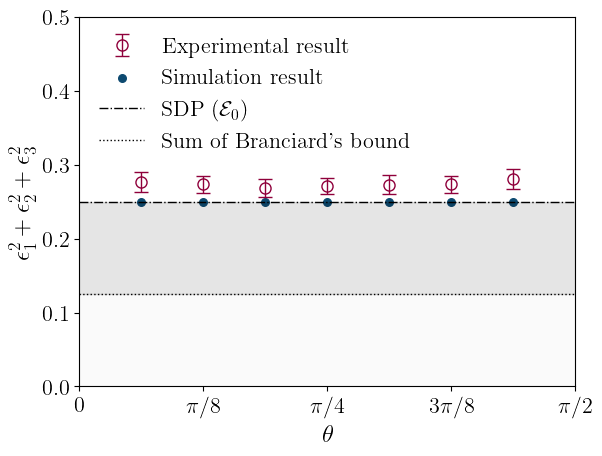

In [22]:
fig, axs = plt.subplots()

# x = thetajexp
x = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
labels = ['0', '$\pi/8$', '$\pi/4$', '$3\pi/8$', '$\pi/2$']

# experimental result on quafu

# axs.scatter(thetajexp, np.array(bk_restore['errList'])[:,0], marker= 'v', s=80, facecolors='none', edgecolors='#c1272d', label='$\mathcal{E}^{\mathrm{exp}}_{\min}$')
# axs.scatter(thetajexp, np.array(bk_restore['errList'])[:,1], marker= '^', s=80, facecolors='none', edgecolors='#c1272d', label='$\mathcal{E}^{\mathrm{exp}}_{\max}$')

axs.errorbar(
    thetajexp,
    Pure_P136_errsum_exp_mean,
    yerr=Pure_P136_errsum_exp_std,
    fmt='o',
    ecolor='#8F003B',
    elinewidth=1,
    capthick=1,
    ms=8,
    mfc = 'none',
    # mfc='#8F003B',
    mec='#8F003B',
    capsize=5,
    clip_on=False,
    label='Experimental result'
)

# experimental result on simulator

axs.scatter(thetajexp, Pure_P136_errsum_simul_mean, marker= 'o', s=30, color='#0D4A70', clip_on=False, label='Simulation result')
# axs.scatter(thetajexp, np.array(bk_restore['errList_simul'])[:,1], marker= 'o', s=60, facecolors='none', edgecolors='#0000a7')


# theoretical bound
axs.plot(thetaj, SDPList, color='black', linestyle='-.', linewidth = 1, label='SDP ($\mathcal{E}_0$)')
# theoretical bound
axs.plot(thetaj, BenchmarkList, color='black', linestyle='dotted', linewidth = 1, label='Sum of Branciard\'s bound')
# forbiden area
axs.fill_between(thetaj, BenchmarkList, SDPList, color='black', alpha=0.1)
axs.fill_between(thetaj, np.zeros(len(thetaj)), BenchmarkList, color='black', alpha=0.02)

xlimit = np.pi/2
ylimit = 0.5
plt.rcParams['text.usetex'] = True
plt.ylim([0, ylimit])
# plt.ylim([0.24, 0.26])
plt.xlim([0, xlimit])
# plt.xticks(np.arange(0, 1.01*xlimit, step=xlimit/5))
plt.xticks(x, labels)
# plt.yticks(np.arange(0.8, 1.01*ylimit, step=ylimit/6))
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\epsilon_1^2+\epsilon_2^2+\epsilon_3^2$')

#add legend to plot
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=2, frameon=False)
# plt.rcParams["font.family"] = "Times New Roman"

plt.savefig('fig.pdf', bbox_inches='tight')
plt.show()